In [15]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from quantecon.markov import DiscreteDP
from numba import jit
from scipy.optimize import brentq

class Household:
    """
    This class takes the parameters that define a household asset accumulation
    problem and computes the corresponding reward and transition matrices R
    and Q required to generate an instance of DiscreteDP, and thereby solve
    for the optimal policy.

    Comments on indexing: We need to enumerate the state space S as a sequence
    S = {0, ..., n}.  To this end, (a_i, z_i) index pairs are mapped to s_i
    indices according to the rule

        s_i = a_i * z_size + z_i

    To invert this map, use

        a_i = s_i // z_size  (integer division)
        z_i = s_i % z_size

    """


    def __init__(self,
                r=0.01,                      # Interest rate
                w=1.0,                       # Wages
                β=0.96,                      # Discount factor
                a_min=1e-10,
                Π=[[0.9, 0.1], [0.1, 0.9]],  # Markov chain
                z_vals=[0.4, 1.0],           # Exogenous states
                a_max=18,
                a_size=200):

        # Store values, set up grids over a and z
        self.r, self.w, self.β = r, w, β
        self.a_min, self.a_max, self.a_size = a_min, a_max, a_size

        self.Π = np.asarray(Π)
        self.z_vals = np.asarray(z_vals)
        self.z_size = len(z_vals)

        self.a_vals = np.linspace(a_min, a_max, a_size)
        self.n = a_size * self.z_size

        # Build the array Q
        self.Q = np.zeros((self.n, a_size, self.n))
        self.build_Q()

        # Build the array R
        self.R = np.empty((self.n, a_size))
        self.build_R()

    def set_prices(self, r, w):
        """
        Use this method to reset prices. Calling the method will trigger a
        re-build of R.
        """
        self.r, self.w = r, w
        self.build_R()

    def build_Q(self):
        populate_Q(self.Q, self.a_size, self.z_size, self.Π)

    def build_R(self):
        self.R.fill(-np.inf)
        populate_R(self.R,
                self.a_size,
                self.z_size,
                self.a_vals,
                self.z_vals,
                self.r,
                self.w)


# Do the hard work using JIT-ed functions

@jit(nopython=True)
def populate_R(R, a_size, z_size, a_vals, z_vals, r, w):
    n = a_size * z_size
    for s_i in range(n):
        a_i = s_i // z_size
        z_i = s_i % z_size
        a = a_vals[a_i]
        z = z_vals[z_i]
        for new_a_i in range(a_size):
            a_new = a_vals[new_a_i]
            c = w * z + (1 + r) * a - a_new
            if c > 0:
                #R[s_i, new_a_i] = np.log(c)  # Utility
                R[s_i, new_a_i] = (c**(1-3) - 1)/(1-3)  # Utility

@jit(nopython=True)
def populate_Q(Q, a_size, z_size, Π):
    n = a_size * z_size
    for s_i in range(n):
        z_i = s_i % z_size
        for a_i in range(a_size):
            for next_z_i in range(z_size):
                Q[s_i, a_i, a_i*z_size + next_z_i] = Π[z_i, next_z_i]


@jit(nopython=True)
def asset_marginal(s_probs, a_size, z_size):
    a_probs = np.zeros(a_size)
    for a_i in range(a_size):
        for z_i in range(z_size):
            a_probs[a_i] += s_probs[a_i*z_size + z_i]
    return a_probs

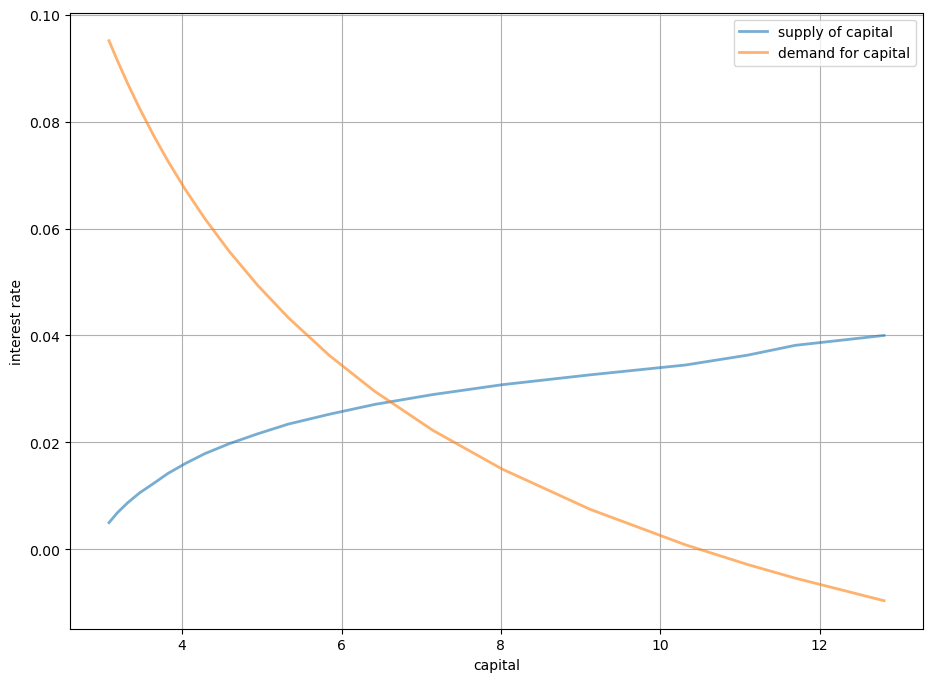

r 0.01 diff 0.07420289257696669
r 0.08 diff -0.10683590584877661
r 0.0386911011648046 diff -0.04508577310207763
r 0.027847149899178383 diff -0.0007776897506967355
r 0.027658792365714252 diff -8.963486112013863e-05
r 0.027634288021037352 diff 0.0001832748668099335
r 0.02765074412372371 diff -8.158661912959636e-05
r 0.02764251607238053 diff -7.335856778641764e-05
r 0.02763840204670894 diff -5.430625872957645e-05
r 0.027636345033873147 diff 0.0001812178539741388
r 0.027637927748472603 diff -5.383196049323774e-05
r 0.027637136391172875 diff 0.00018042649667441082
r 0.027637745896703366 diff -5.365010872400086e-05
r 0.02763744114393812 diff 0.00018012174390916527
r 0.027637675956636566 diff -5.3580168657200306e-05
r 0.027637558550287343 diff -5.346276230797781e-05
r 0.02763749984711273 diff 0.00018006304073455576
r 0.027637545110942182 diff 0.00018001777690510382
r 0.02763755547292373 diff 0.0001800074149235567
r 0.02763755784559623 diff -5.346205761686332e-05
r 0.02763755665925998 diff 0.0

In [17]:
A = 1.0
N = 1.0
α = 0.36
β = 0.96
δ = 0.08


def r_to_w(r):
    """
    Equilibrium wages associated with a given interest rate r.
    """
    return A * (1 - α) * (A * α / (r + δ))**(α / (1 - α))

def rd(K):
    """
    Inverse demand curve for capital.  The interest rate associated with a
    given demand for capital K.
    """
    return A * α * (N / K)**(1 - α) - δ


def prices_to_capital_stock(am, r):
    """
    Map prices to the induced level of capital stock.

    Parameters:
    ----------

    am : Household
        An instance of an aiyagari_household.Household
    r : float
        The interest rate
    """
    w = r_to_w(r)
    am.set_prices(r, w)
    aiyagari_ddp = DiscreteDP(am.R, am.Q, β)
    # Compute the optimal policy
    results = aiyagari_ddp.solve(method='policy_iteration')
    # Compute the stationary distribution
    stationary_probs = results.mc.stationary_distributions[0]
    # Extract the marginal distribution for assets
    asset_probs = asset_marginal(stationary_probs, am.a_size, am.z_size)
    # Return K
    return np.sum(asset_probs * am.a_vals)


# Create an instance of Household
am = Household(a_max=20)

# Use the instance to build a discrete dynamic program
am_ddp = DiscreteDP(am.R, am.Q, am.β)

def eqbm_func(r):
    calculated = rd(prices_to_capital_stock(am, r))
    print("r", r, "diff", calculated - r)
    return calculated - r

# Create a grid of r values at which to compute demand and supply of capital
num_points = 20
r_vals = np.linspace(0.005, 0.04, num_points)

# Compute supply of capital
k_vals = np.empty(num_points)
for i, r in enumerate(r_vals):
    k_vals[i] = prices_to_capital_stock(am, r)

# Plot against demand for capital by firms
fig, ax = plt.subplots(figsize=(11, 8))
ax.plot(k_vals, r_vals, lw=2, alpha=0.6, label='supply of capital')
ax.plot(k_vals, rd(k_vals), lw=2, alpha=0.6, label='demand for capital')
ax.grid()
ax.set_xlabel('capital')
ax.set_ylabel('interest rate')
ax.legend(loc='upper right')

plt.show()

R_star = 1 + brentq(eqbm_func, 0.01, 0.08)
print(R_star)